In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainingArguments, SentenceTransformerTrainer, InputExample
from sentence_transformers.losses import CosineSimilarityLoss, MultipleNegativesRankingLoss
from sentence_transformers.evaluation import InformationRetrievalEvaluator
from sentence_transformers.training_args import BatchSamplers
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [3]:
from huggingface_hub import notebook_login
notebook_login()

In [4]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [5]:
df = pd.read_csv('/content/drive/MyDrive/inference.csv')

In [6]:
all_title = []
all_q = []
all_synop = []
all_index = []
all_text = []
for i in range(len(df)):
  if isinstance(df.loc[i, "q"], str):
    all_q.append(df.loc[i, "q"].split('\n')[0])
    all_synop.append(str(df.loc[i, 'synopsis']))
    all_title.append(str(df.loc[i, 'title']))
    all_index.append(i)
    all_text.append(str(df.loc[i, 'text_corpus']))

In [7]:
x_train, x_temp, y_train, y_temp = train_test_split(all_q, all_synop, test_size = 0.2, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size = 0.5, random_state = 42)

In [8]:
train_ex = []
for i in range(len(x_train)):
  train_ex.append(InputExample(texts = [str(x_train[i]), str(y_train[i])], label = 1.0))
for i in range(len(x_train)):
  rand_idx_synop = random.randint(0, len(x_train) - 1)
  rand_idx_q = random.randint(0, len(y_train) - 1)
  while rand_idx_synop == rand_idx_q:
    rand_idx_q = random.randint(0, len(y_train) - 1)
  train_ex.append(InputExample(texts = [str(x_train[rand_idx_synop]), str(y_train[rand_idx_q])], label = 0.0))

In [9]:
train_data = DataLoader(train_ex, batch_size = 16)
train_loss = CosineSimilarityLoss(model)

In [ ]:
model.fit(train_objectives = [(train_data, train_loss)],
          epochs = 4, warmup_steps = 100, show_progress_bar = True)

In [12]:
model.save_pretrained("models/anime-recommend-mpnet-v3")

In [13]:
model = SentenceTransformer("/content/models/anime-recommend-mpnet-v3")

In [14]:
all2_title = []
#all_q = []
all2_synop = []
all2_index = []
all2_text = []
for i in range(len(df)):
  #if isinstance(infer_df.loc[i, "q"], str):
    #all_q.append(infer_df.loc[i, "q"].split('\n')[0])
    all2_synop.append(str(df.loc[i, 'synopsis']))
    all2_title.append(str(df.loc[i, 'title']))
    all2_index.append(i)
    all2_text.append(str(df.loc[i, 'text_corpus']))

In [16]:
val_q = x_test

In [17]:
all_val_q = []
label = []
for i in range(len(val_q)):
  embedding_q = model.encode(val_q[i], convert_to_tensor = True)
  idxx = all_q.index(val_q[i])
  label.append(idxx)
  all_val_q.append(embedding_q)

In [18]:
embedding_synop = model.encode(all_synop, convert_to_tensor = True)

In [20]:
from sentence_transformers import util
acc = 0
n_val = len(all_val_q)
topk = 5
for i in range(n_val):
  cosine_score = util.cos_sim(all_val_q[i], embedding_synop)
  all_idx = torch.topk(cosine_score.flatten(), topk).indices
  answer = all_idx.tolist() # Convert tensor indices to a list
  if label[i] in answer: # Check if the true index is in the topk predictions
    acc += 1

print(f"Accuracy@ topk = {topk}: {acc / n_val}")

Accuracy@ topk = 5: 0.7938144329896907


In [21]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
embedding_infer = model.encode(all2_text, convert_to_tensor = True)

In [37]:
query = input("Enter your query: ")
q_encode = model.encode(query, convert_to_tensor = True)

Enter your query: koto a traditional japanese instrument high school club


tensor([ 534, 3984,  856,  741,  792], device='cuda:0')
Here is the anime recommend from this query: koto a traditional japanese instrument high school club

Name:  K-On!
Similarity score:  0.878290057182312


array([[[ 75, 202, 247],
        [ 75, 202, 247],
        [ 75, 202, 247],
        ...,
        [ 75, 203, 248],
        [ 75, 203, 248],
        [ 75, 203, 248]],

       [[ 25, 167, 217],
        [ 25, 167, 217],
        [ 25, 167, 217],
        ...,
        [ 26, 168, 218],
        [ 26, 168, 218],
        [ 26, 168, 218]],

       [[  6, 169, 228],
        [  6, 169, 228],
        [  6, 169, 226],
        ...,
        [  8, 168, 226],
        [  8, 168, 226],
        [  8, 168, 226]],

       ...,

       [[  0, 171, 229],
        [  0, 171, 229],
        [  0, 171, 229],
        ...,
        [  0, 171, 229],
        [  0, 171, 229],
        [  0, 171, 231]],

       [[ 22, 169, 220],
        [ 22, 169, 220],
        [ 22, 169, 220],
        ...,
        [ 22, 169, 220],
        [ 22, 169, 220],
        [ 23, 169, 218]],

       [[ 88, 205, 249],
        [ 88, 205, 249],
        [ 88, 205, 249],
        ...,
        [ 88, 205, 249],
        [ 88, 205, 249],
        [ 87, 206, 246]]], dtype=uint8)
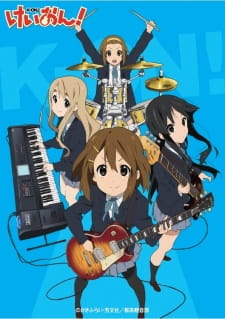

Name:  Kiniro no Corda: Blue♪Sky
Similarity score:  0.8086947202682495


array([[[ 74, 154, 225],
        [ 74, 154, 225],
        [ 73, 153, 224],
        ...,
        [254, 255, 255],
        [254, 255, 255],
        [255, 255, 255]],

       [[ 74, 154, 225],
        [ 74, 154, 225],
        [ 73, 153, 224],
        ...,
        [254, 255, 255],
        [254, 255, 255],
        [255, 255, 255]],

       [[ 74, 154, 225],
        [ 74, 154, 225],
        [ 74, 154, 225],
        ...,
        [254, 255, 255],
        [254, 255, 255],
        [255, 255, 255]],

       ...,

       [[183, 247, 255],
        [175, 237, 250],
        [177, 239, 250],
        ...,
        [131, 206, 245],
        [130, 205, 244],
        [138, 214, 250]],

       [[182, 244, 255],
        [180, 240, 251],
        [187, 245, 255],
        ...,
        [131, 206, 245],
        [131, 206, 245],
        [139, 215, 251]],

       [[178, 241, 248],
        [185, 245, 253],
        [195, 252, 255],
        ...,
        [131, 206, 245],
        [131, 206, 245],
        [139, 215, 251]]], dtype=uint8)
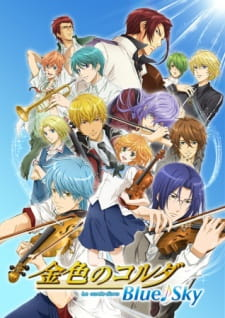

Name:  Ongaku
Similarity score:  0.7947843670845032


array([[[250, 250, 248],
        [250, 250, 248],
        [244, 244, 242],
        ...,
        [210, 210, 208],
        [205, 205, 203],
        [204, 204, 202]],

       [[247, 247, 245],
        [248, 248, 246],
        [248, 248, 246],
        ...,
        [207, 209, 206],
        [203, 205, 202],
        [204, 206, 203]],

       [[249, 248, 246],
        [247, 246, 244],
        [250, 249, 247],
        ...,
        [212, 214, 211],
        [207, 212, 208],
        [207, 209, 206]],

       ...,

       [[241, 236, 240],
        [243, 241, 242],
        [241, 239, 240],
        ...,
        [246, 246, 246],
        [242, 242, 242],
        [238, 238, 236]],

       [[242, 237, 241],
        [244, 242, 245],
        [245, 243, 244],
        ...,
        [244, 244, 246],
        [240, 240, 242],
        [244, 244, 242]],

       [[244, 239, 243],
        [244, 242, 245],
        [250, 248, 249],
        ...,
        [241, 241, 243],
        [238, 238, 240],
        [242, 242, 240]]], dtype=uint8)
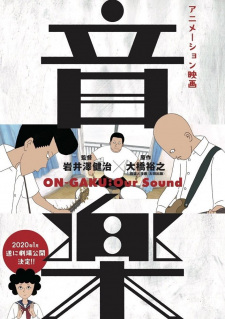

Name:  Hibike! Euphonium: Ensemble Contest-hen
Similarity score:  0.7926118969917297


array([[[255, 255, 255],
        [254, 254, 254],
        [253, 253, 253],
        ...,
        [255, 254, 255],
        [255, 254, 252],
        [255, 255, 255]],

       [[254, 254, 254],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[253, 253, 253],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [253, 255, 254],
        [252, 254, 253],
        [255, 255, 255]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]]], dtype=uint8)
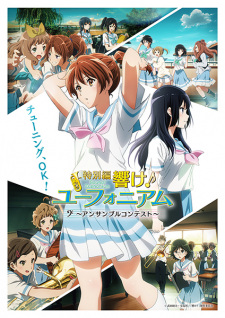

Name:  Kimi no Iro
Similarity score:  0.7892798781394958


array([[[241, 247, 243],
        [239, 248, 243],
        [235, 245, 237],
        ...,
        [222, 236, 210],
        [215, 234, 204],
        [230, 241, 237]],

       [[243, 247, 246],
        [243, 249, 247],
        [242, 248, 244],
        ...,
        [228, 235, 217],
        [216, 227, 223],
        [240, 244, 243]],

       [[241, 245, 246],
        [241, 245, 244],
        [241, 247, 245],
        ...,
        [220, 212, 191],
        [238, 217, 216],
        [245, 240, 246]],

       ...,

       [[227, 241, 252],
        [226, 240, 251],
        [227, 241, 252],
        ...,
        [227, 241, 252],
        [227, 241, 252],
        [227, 241, 252]],

       [[227, 241, 252],
        [226, 240, 251],
        [226, 240, 251],
        ...,
        [226, 240, 251],
        [226, 240, 251],
        [226, 240, 251]],

       [[226, 240, 251],
        [226, 240, 251],
        [226, 240, 251],
        ...,
        [226, 240, 251],
        [226, 240, 251],
        [226, 240, 251]]], dtype=uint8)
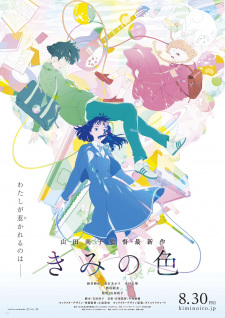

In [38]:
import imageio.v3 as imageio
cosine_score = util.cos_sim(q_encode, embedding_infer)
all_index = torch.topk(cosine_score.flatten(), 5).indices
print(all_index)
print(f"Here is the anime recommend from this query: {query}\n")
for i in range(len(all_index)):
  print("Name: ", df.loc[all_index[i].item(), "title"])
  print("Similarity score: ", cosine_score.flatten()[all_index[i].item()].item())
  img_url = df.loc[all_index[i].item(), "image_jpg_url"]
  img = imageio.imread(img_url)
  display(img)

In [ ]:
model.push_to_hub('KiruruP/anime-recommendation-multilingual-mpnet-base-v2-final')

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...tmpqbk2jz_n/sentencepiece.bpe.model: 100%|##########| 5.07MB / 5.07MB            

  /tmp/tmpqbk2jz_n/model.safetensors    :   0%|          |  556kB / 1.11GB            

  /tmp/tmpqbk2jz_n/tokenizer.json       : 100%|##########| 17.1MB / 17.1MB            

'https://huggingface.co/KiruruP/anime-recommendation-multilingual-mpnet-base-v2-final/commit/836e5ea403bc9b6052fd01bad1f4099c81d49fac'

# **test lora**

In [ ]:
from peft import LoraConfig, TaskType

In [ ]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

In [ ]:
peft_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
)

In [ ]:
model.add_adapter(peft_config)

In [ ]:
model.fit(train_objectives = [(train_data, train_loss)],
          epochs = 6, warmup_steps = 100, show_progress_bar = True)

Step,Training Loss
500,0.053600
1000,0.051100


In [ ]:
model.save_pretrained("models/anime-recommend-mpnet-v3_peft")

In [ ]:
model = SentenceTransformer("models/anime-recommend-mpnet-v3_peft")

In [ ]:
all_val_q = []
label = []
for i in range(len(val_q)):
  embedding_q = model.encode(val_q[i], convert_to_tensor = True)
  idxx = all_q.index(val_q[i])
  label.append(idxx)
  all_val_q.append(embedding_q)

In [ ]:
embedding_synop = model.encode(all_synop, convert_to_tensor=True)

In [ ]:
from sentence_transformers import util
acc = 0
n_val = len(all_val_q)
topk = 5
for i in range(n_val):
  cosine_score = util.cos_sim(all_val_q[i], embedding_synop)
  all_idx = torch.topk(cosine_score.flatten(), topk).indices
  answer = all_idx.tolist() # Convert tensor indices to a list
  if label[i] in answer: # Check if the true index is in the topk predictions
    acc += 1

print(f"Accuracy@ topk = {topk}: {acc / n_val}")

Accuracy@ topk = 5: 0.8969072164948454


In [ ]:
all2_title = []
#all_q = []
all2_synop = []
all2_index = []
for i in range(len(infer_df)):
  #if isinstance(infer_df.loc[i, "q"], str):
    #all_q.append(infer_df.loc[i, "q"].split('\n')[0])
    all2_synop.append(str(infer_df.loc[i, 'synopsis']))
    all2_title.append(str(infer_df.loc[i, 'title']))
    all2_index.append(i)

In [ ]:
embedding_infer = model.encode(all2_synop, convert_to_tensor = True)

In [ ]:
query = input("Enter your query: ")
q_encode = model.encode(query, convert_to_tensor = True)

Enter your query: anime about volleyball high school boys


tensor([ 106,  134, 4050], device='cuda:0')
Here is the anime recommend from this query: anime about volleyball high school boys

Name:  Haikyuu!!
Similarity score:  0.827905535697937


array([[[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [252, 254, 253],
        [252, 254, 253],
        [253, 253, 253]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [252, 254, 253],
        [252, 254, 253],
        [253, 253, 253]],

       [[253, 253, 253],
        [253, 253, 253],
        [253, 253, 253],
        ...,
        [252, 254, 253],
        [252, 254, 253],
        [253, 253, 253]],

       ...,

       [[ 89, 158, 111],
        [ 94, 159, 116],
        [106, 164, 123],
        ...,
        [129, 128, 123],
        [196, 195, 190],
        [233, 229, 226]],

       [[ 70, 161, 100],
        [ 70, 158, 100],
        [ 83, 160, 106],
        ...,
        [197, 196, 191],
        [205, 204, 199],
        [229, 228, 223]],

       [[ 63, 154,  93],
        [ 64, 152,  94],
        [ 77, 154, 100],
        ...,
        [225, 224, 219],
        [231, 230, 225],
        [229, 228, 223]]], dtype=uint8)
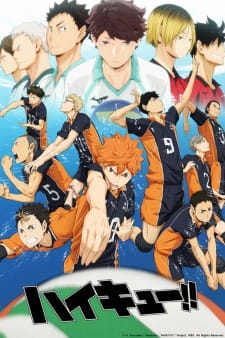

Name:  Haikyuu!! To the Top
Similarity score:  0.8233155012130737


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 177,  98],
        [249, 175, 102],
        [244, 180, 119]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [252, 173,  94],
        [245, 171,  98],
        [240, 176, 114]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [251, 173,  91],
        [245, 171,  96],
        [240, 179, 116]],

       ...,

       [[239, 142,  87],
        [237, 138,  83],
        [240, 133,  81],
        ...,
        [250, 163,  86],
        [248, 168,  95],
        [242, 176, 115]],

       [[234, 138,  88],
        [235, 135,  86],
        [239, 131,  84],
        ...,
        [253, 167,  90],
        [246, 168,  94],
        [242, 178, 116]],

       [[231, 135,  87],
        [233, 132,  86],
        [237, 130,  84],
        ...,
        [255, 172,  94],
        [248, 172,  97],
        [240, 176, 114]]], dtype=uint8)
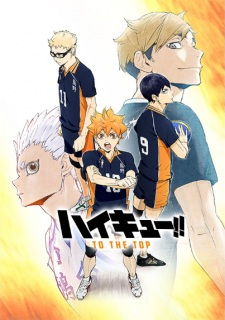

Name:  Ashita e Attack!
Similarity score:  0.7945131659507751


array([[[127, 175, 195],
        [127, 175, 195],
        [129, 177, 197],
        ...,
        [108, 159, 180],
        [105, 156, 177],
        [103, 154, 175]],

       [[127, 175, 195],
        [125, 173, 193],
        [125, 173, 193],
        ...,
        [107, 158, 179],
        [104, 155, 176],
        [102, 153, 174]],

       [[126, 174, 194],
        [123, 171, 191],
        [124, 172, 192],
        ...,
        [106, 157, 178],
        [104, 155, 176],
        [102, 153, 174]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [186, 186, 186],
        [178, 178, 178],
        [244, 244, 244]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [209, 209, 209],
        [192, 192, 192],
        [245, 245, 245]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [250, 250, 250],
        [247, 247, 247],
        [248, 248, 248]]], dtype=uint8)
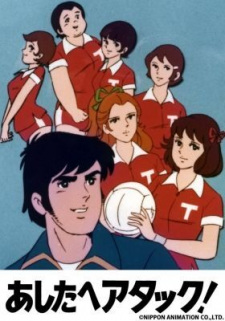

In [ ]:
import imageio.v3 as imageio
cosine_score = util.cos_sim(q_encode, embedding_infer)
all_index = torch.topk(cosine_score.flatten(), 3).indices
print(all_index)
print(f"Here is the anime recommend from this query: {query}\n")
for i in range(len(all_index)):
  print("Name: ", df.loc[all_index[i].item(), "title"])
  print("Similarity score: ", cosine_score.flatten()[all_index[i].item()].item())
  img_url = df.loc[all_index[i].item(), "image_jpg_url"]
  img = imageio.imread(img_url)
  display(img)

tensor([3421,  922,  270], device='cuda:0')
Here is the anime recommend from this query: What is the name of the story about a legendary hitman who gets married and has a baby?

Name:  Ninja Kamui
Similarity score:  0.5932754278182983


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [240,  90,  92],
        [247, 174, 167],
        [251, 247, 244]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 234, 236],
        [248, 209, 210],
        [247, 173, 172]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [247, 199, 199],
        [247, 211, 213],
        [254, 234, 235]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [255, 255, 255]]], dtype=uint8)
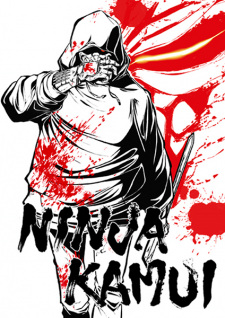

Name:  Sakamoto Days
Similarity score:  0.5577198266983032


array([[[249, 250, 245],
        [248, 250, 237],
        [250, 253, 226],
        ...,
        [191, 218, 213],
        [179, 216, 222],
        [173, 205, 218]],

       [[255, 252, 223],
        [255, 254, 217],
        [255, 253, 200],
        ...,
        [196, 216, 188],
        [182, 214, 201],
        [173, 207, 209]],

       [[255, 243, 168],
        [255, 243, 158],
        [255, 242, 138],
        ...,
        [205, 213, 138],
        [187, 209, 162],
        [171, 203, 188]],

       ...,

       [[241, 227, 201],
        [241, 227, 201],
        [241, 227, 201],
        ...,
        [245, 236, 221],
        [244, 235, 220],
        [247, 235, 219]],

       [[237, 225, 199],
        [238, 226, 200],
        [239, 227, 201],
        ...,
        [250, 241, 226],
        [243, 236, 218],
        [244, 235, 218]],

       [[229, 224, 195],
        [232, 227, 198],
        [235, 230, 201],
        ...,
        [244, 239, 220],
        [239, 234, 214],
        [234, 227, 208]]], dtype=uint8)
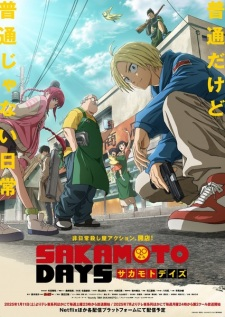

Name:  Cang Yuan Tu
Similarity score:  0.5393410921096802


array([[[ 1,  5,  8],
        [ 0,  1,  5],
        [ 6,  7, 11],
        ...,
        [ 3,  6, 13],
        [ 5,  6, 11],
        [ 5,  6, 11]],

       [[ 0,  1,  5],
        [ 0,  1,  5],
        [ 5,  6, 10],
        ...,
        [ 3,  6, 13],
        [ 5,  6, 11],
        [ 6,  7, 12]],

       [[ 1,  2,  6],
        [ 2,  3,  7],
        [ 3,  4,  8],
        ...,
        [ 2,  5, 10],
        [ 6,  7, 12],
        [ 6,  7, 12]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  1,  0],
        [ 0,  1,  0],
        [ 0,  1,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  1,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 2,  2,  2],
        [ 4,  4,  4],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)
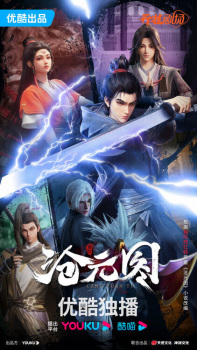

In [ ]:
import imageio.v3 as imageio
cosine_score = util.cos_sim(q_encode, embedding_infer)
all_index = torch.topk(cosine_score.flatten(), 3).indices
print(all_index)
print(f"Here is the anime recommend from this query: {query}\n")
for i in range(len(all_index)):
  print("Name: ", df.loc[all_index[i].item(), "title"])
  print("Similarity score: ", cosine_score.flatten()[all_index[i].item()].item())
  img_url = df.loc[all_index[i].item(), "image_jpg_url"]
  img = imageio.imread(img_url)
  display(img)

In [ ]:
model.push_to_hub('KiruruP/anime-recommendation-multilingual-mpnet-base-v2-peft')

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...tmpw8_yqdcv/sentencepiece.bpe.model: 100%|##########| 5.07MB / 5.07MB            

  /tmp/tmpw8_yqdcv/tokenizer.json       : 100%|##########| 17.1MB / 17.1MB            

  ...pw8_yqdcv/adapter_model.safetensors:  48%|####7     |  565kB / 1.19MB            

'https://huggingface.co/KiruruP/anime-recommendation-multilingual-mpnet-base-v2-peft/commit/3eca4dc22363265a476003a4ff18bd4d7fda1d1a'

## Test actual inference by calling the model from hub

In [ ]:
model = SentenceTransformer('KiruruP/anime-recommendation-multilingual-mpnet-base-v2-peft')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/283 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/312 [00:00<?, ?B/s]

In [ ]:
embedding_infer = model.encode(all2_synop, convert_to_tensor = True)

In [ ]:
query = input("Enter your query: ")
q_encode = model.encode(query, convert_to_tensor = True)

Enter your query: guitar and mysterious circumstances


tensor([161, 333,  25], device='cuda:0')
Here is the anime recommend from this query: guitar and mysterious circumstances

Name:  Given
Similarity score:  0.6560174822807312


array([[[177,  96,  53],
        [193, 105,  67],
        [199,  99,  67],
        ...,
        [ 83,  76,  83],
        [ 89,  83,  87],
        [ 92,  82,  83]],

       [[191, 107,  70],
        [194, 104,  69],
        [199,  95,  66],
        ...,
        [ 86,  80,  84],
        [ 90,  81,  84],
        [102,  88,  85]],

       [[200, 109,  80],
        [192,  97,  69],
        [202,  93,  70],
        ...,
        [ 88,  82,  86],
        [ 90,  79,  77],
        [123, 104,  90]],

       ...,

       [[213, 197, 164],
        [244, 228, 195],
        [242, 225, 195],
        ...,
        [147, 143, 131],
        [205, 201, 189],
        [243, 239, 227]],

       [[216, 200, 166],
        [242, 226, 192],
        [242, 226, 193],
        ...,
        [199, 197, 184],
        [230, 228, 215],
        [243, 239, 227]],

       [[215, 199, 165],
        [241, 225, 191],
        [241, 225, 192],
        ...,
        [235, 233, 220],
        [246, 244, 231],
        [244, 240, 228]]], dtype=uint8)
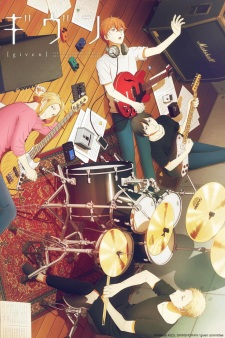

Name:  BanG Dream! Ave Mujica
Similarity score:  0.6418615579605103


array([[[28,  1,  8],
        [28,  1,  8],
        [29,  0,  7],
        ...,
        [23,  0,  8],
        [23,  0,  8],
        [22,  1,  8]],

       [[28,  1,  8],
        [27,  0,  7],
        [29,  0,  7],
        ...,
        [23,  0,  8],
        [23,  0,  8],
        [22,  1,  8]],

       [[26,  1,  7],
        [27,  0,  7],
        [29,  0,  7],
        ...,
        [23,  0,  8],
        [23,  0,  8],
        [24,  1,  9]],

       ...,

       [[11, 26, 33],
        [13, 26, 34],
        [13, 26, 34],
        ...,
        [22, 21, 35],
        [22, 24, 37],
        [18, 21, 36]],

       [[13, 26, 35],
        [14, 27, 35],
        [14, 27, 33],
        ...,
        [21, 24, 39],
        [19, 22, 37],
        [17, 23, 37]],

       [[13, 26, 35],
        [14, 27, 35],
        [15, 28, 34],
        ...,
        [21, 27, 41],
        [20, 26, 40],
        [20, 26, 40]]], dtype=uint8)
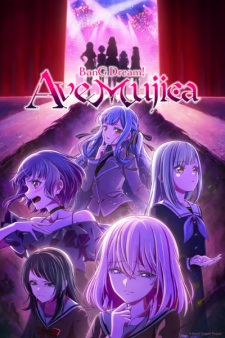

Name:  Bocchi the Rock!
Similarity score:  0.6413174867630005


array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
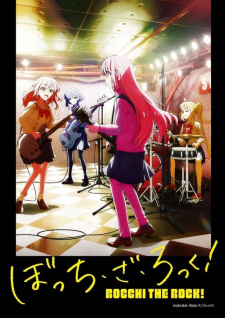

In [ ]:
import imageio.v3 as imageio
cosine_score = util.cos_sim(q_encode, embedding_infer)
all_index = torch.topk(cosine_score.flatten(), 3).indices
print(all_index)
print(f"Here is the anime recommend from this query: {query}\n")
for i in range(len(all_index)):
  print("Name: ", df.loc[all_index[i].item(), "title"])
  print("Similarity score: ", cosine_score.flatten()[all_index[i].item()].item())
  img_url = df.loc[all_index[i].item(), "image_jpg_url"]
  img = imageio.imread(img_url)
  display(img)